<a href="https://colab.research.google.com/github/emiliomercuri/IoT-AI_Forest_Summer_School_2024/blob/main/code/CO2_forecast_with_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Can we use AI to predict CO2 inside the Forest?

We have used IoT, a phone, CO2 sensors and power banks to measure CO2 concentration in ppm, relative humidity (%) and temperature (celsius) inside the forest.

Actually it was at a standing tree, a bush and in the cottage, look some pictures:

In [1]:
!gdown 1j_hcwLylVo23DEd_R94ZF3BXn-DQHXH3
!unzip co2_measurement_pictures.zip

Downloading...
From (original): https://drive.google.com/uc?id=1j_hcwLylVo23DEd_R94ZF3BXn-DQHXH3
From (redirected): https://drive.google.com/uc?id=1j_hcwLylVo23DEd_R94ZF3BXn-DQHXH3&confirm=t&uuid=febe2242-390b-402b-8858-c61050a570e6
To: /content/co2_measurement_pictures.zip
100% 112M/112M [00:07<00:00, 15.1MB/s]
Archive:  co2_measurement_pictures.zip
  inflating: IMG_5021.png            
  inflating: IMG_5027.png            
  inflating: IMG_5016.png            
  inflating: IMG_5025.png            
  inflating: IMG_5047.png            


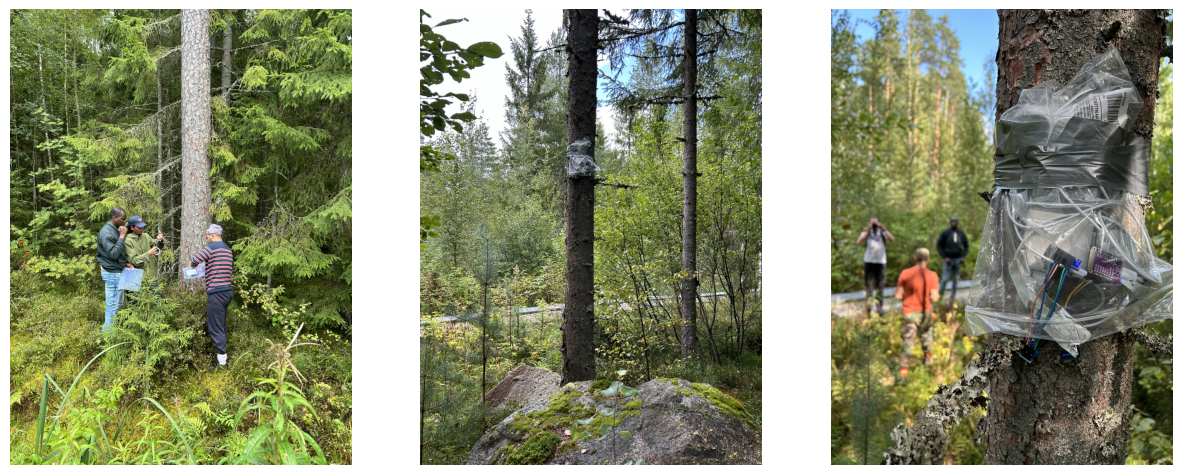

In [2]:
# prompt: show into colab the png pictures
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img1 = mpimg.imread('IMG_5021.png')
img2 = mpimg.imread('IMG_5025.png')
img3 = mpimg.imread('IMG_5047.png')

plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(img1)
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(img2)
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(img3)
plt.axis('off')
plt.show()

## Importing the libraries

In [3]:
import numpy as np
from os import system
from urllib.request import urlretrieve
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DayLocator, HourLocator, DateFormatter, drange
from datetime import datetime
from sklearn import linear_model
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Let's download the data we have collected

I have only selected Emilio's and Dimitrii's CO2 data because the time series look good, and also we were together in the bush.. ❤️

In [4]:
!gdown 1wpvfBBBnbpUHa6AjJXifQUXeC_r5VgHu

Downloading...
From: https://drive.google.com/uc?id=1wpvfBBBnbpUHa6AjJXifQUXeC_r5VgHu
To: /content/CO2_jarvselja_IOT+Forestry_SS2024.csv
100% 212k/212k [00:00<00:00, 84.1MB/s]


## Correct the time stamp and make some graphs

In [5]:
data = pd.read_csv("CO2_jarvselja_IOT+Forestry_SS2024.csv")
data

,timestamp,emilio-CO2ppm,dmitrii-CO2ppm,emilio-temp,dmitrii-temp,emilio-humidity,dmitrii-humidity
0,2024-08-17 09:30:00,509.666667,476.6,28.752467,27.386170,64.638773,67.280884
1,2024-08-17 09:31:00,515.250000,484.0,28.751354,27.544784,64.817429,67.764892
2,2024-08-17 09:32:00,523.000000,492.8,28.694610,27.709808,64.765930,68.044433
3,2024-08-17 09:33:00,525.333333,497.0,28.644543,27.828369,64.599991,67.800903
4,2024-08-17 09:34:00,525.600000,501.0,28.603821,27.872830,64.886169,67.894363
...,...,...,...,...,...,...,...
2396,2024-08-19 01:26:00,690.000000,809.0,19.984131,20.112305,67.198181,67.381287
2397,2024-08-19 01:27:00,693.000000,810.0,20.005493,20.112305,67.184448,67.448425
2398,2024-08-19 01:28:00,705.000000,817.0,19.976120,20.077591,67.173767,67.471313
2399,2024-08-19 01:29:00,711.000000,826.0,20.002823,20.053558,67.160034,67.530823


In [6]:
# Transforming the timestamp into datetime (python)
data2 = data.copy()
data2['timestamp'] = pd.to_datetime(data2['timestamp'])
#data2.set_index('timestamp')

In [7]:
# prompt: correct from UK time to Estonia time
# Correct from UK time to Estonia time
data2['timestamp'] = pd.to_datetime(data2['timestamp']) + pd.Timedelta(hours=2)
data2

,timestamp,emilio-CO2ppm,dmitrii-CO2ppm,emilio-temp,dmitrii-temp,emilio-humidity,dmitrii-humidity
0,2024-08-17 11:30:00,509.666667,476.6,28.752467,27.386170,64.638773,67.280884
1,2024-08-17 11:31:00,515.250000,484.0,28.751354,27.544784,64.817429,67.764892
2,2024-08-17 11:32:00,523.000000,492.8,28.694610,27.709808,64.765930,68.044433
3,2024-08-17 11:33:00,525.333333,497.0,28.644543,27.828369,64.599991,67.800903
4,2024-08-17 11:34:00,525.600000,501.0,28.603821,27.872830,64.886169,67.894363
...,...,...,...,...,...,...,...
2396,2024-08-19 03:26:00,690.000000,809.0,19.984131,20.112305,67.198181,67.381287
2397,2024-08-19 03:27:00,693.000000,810.0,20.005493,20.112305,67.184448,67.448425
2398,2024-08-19 03:28:00,705.000000,817.0,19.976120,20.077591,67.173767,67.471313
2399,2024-08-19 03:29:00,711.000000,826.0,20.002823,20.053558,67.160034,67.530823


# How much data is missing?

In [8]:
data2.isna().sum()

,0
timestamp,0
emilio-CO2ppm,34
dmitrii-CO2ppm,47
emilio-temp,33
dmitrii-temp,47
emilio-humidity,34
dmitrii-humidity,47


If we make 5 minutes averages, we may remove this errors.

In [9]:
data3 = data2.copy()
data3.index = data3['timestamp']

data_5min = data3.resample('5min').mean()
data_5min.isna().sum()

,0
timestamp,0
emilio-CO2ppm,1
dmitrii-CO2ppm,1
emilio-temp,1
dmitrii-temp,1
emilio-humidity,1
dmitrii-humidity,1


In [10]:
# prompt: drop missing data from dataframe
data_5min = data_5min.dropna()
data_5min.isna().sum()

,0
timestamp,0
emilio-CO2ppm,0
dmitrii-CO2ppm,0
emilio-temp,0
dmitrii-temp,0
emilio-humidity,0
dmitrii-humidity,0


In [11]:
data_5min.reset_index(drop=True, inplace=True)
data_5min

,timestamp,emilio-CO2ppm,dmitrii-CO2ppm,emilio-temp,dmitrii-temp,emilio-humidity,dmitrii-humidity
0,2024-08-17 11:32:00,519.770000,490.280000,28.689359,27.668392,64.741658,67.757095
1,2024-08-17 11:37:00,530.250000,504.213333,28.194210,27.326462,64.608415,67.698639
2,2024-08-17 11:42:00,503.923333,481.373333,27.522327,26.217277,64.718435,67.794027
3,2024-08-17 11:47:00,519.890000,497.283333,27.448085,26.569729,64.751089,67.682368
4,2024-08-17 11:52:00,503.210000,482.480000,27.099434,26.533279,64.493510,67.313354
...,...,...,...,...,...,...,...
475,2024-08-19 03:12:00,680.800000,750.800000,20.105896,20.135269,67.207336,67.576599
476,2024-08-19 03:17:00,665.500000,748.000000,20.030861,20.135002,67.091370,67.386628
477,2024-08-19 03:22:00,664.400000,755.400000,19.971313,20.104828,67.116699,67.342529
478,2024-08-19 03:27:00,699.400000,813.800000,19.994812,20.097351,67.184753,67.443848


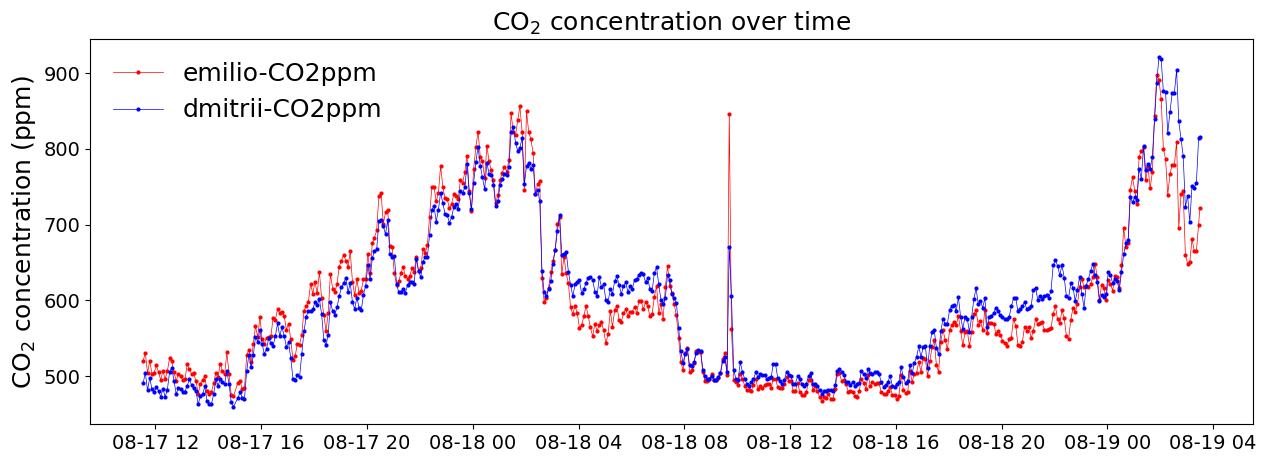

In [12]:
plt.figure(figsize=(15,5))

plt.tick_params(axis='both', labelsize=14) #increase font size for ticks

# Plot the predicted values
plt.plot(data_5min['timestamp'], data_5min['emilio-CO2ppm'], '-ro', linewidth=0.5, markersize=2, label = 'emilio-CO2ppm')
plt.plot(data_5min['timestamp'], data_5min['dmitrii-CO2ppm'], '-bo', linewidth=0.5, markersize=2, label = 'dmitrii-CO2ppm')
#plt.xlabel('Time')
plt.ylabel(r'CO$_2$ concentration (ppm)', fontsize=18)
plt.title(r'CO$_2$ concentration over time', fontsize=18)
#plt.grid(True)
plt.legend(loc="best", frameon=False, fontsize=18)

plt.show();

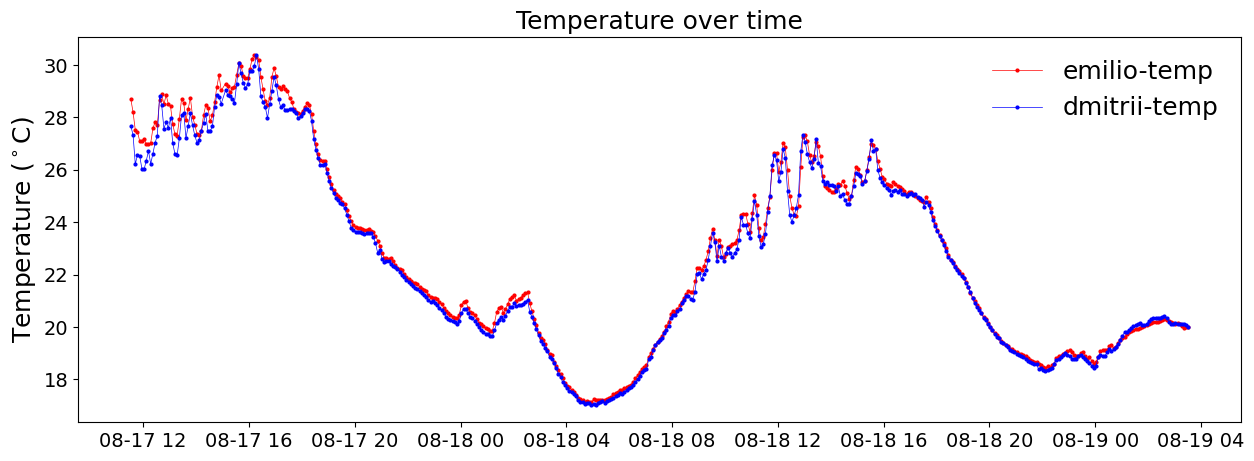

In [13]:
# prompt: replicate the same graph for temperature

import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))

plt.tick_params(axis='both', labelsize=14) #increase font size for ticks

# Plot the predicted values
plt.plot(data_5min['timestamp'], data_5min['emilio-temp'], '-ro', linewidth=0.5, markersize=2, label = 'emilio-temp')
plt.plot(data_5min['timestamp'], data_5min['dmitrii-temp'], '-bo', linewidth=0.5, markersize=2, label = 'dmitrii-temp')
#plt.xlabel('Time')
plt.ylabel(r'Temperature ($^\circ$C)', fontsize=18)
plt.title(r'Temperature over time', fontsize=18)
#plt.grid(True)
plt.legend(loc="best", frameon=False, fontsize=18)

plt.show();


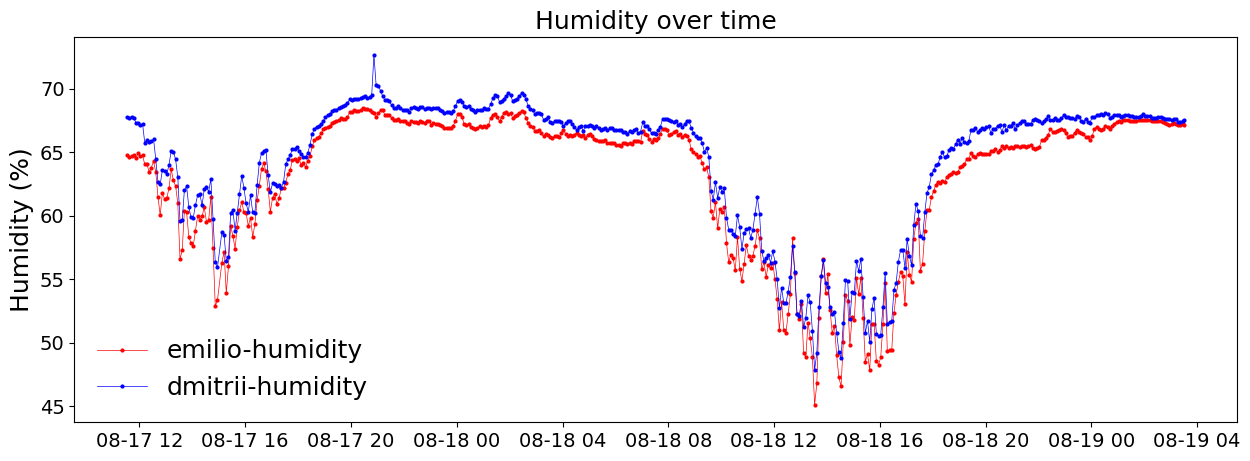

In [14]:
# prompt: replicate the same graph for humidity

import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))

plt.tick_params(axis='both', labelsize=14) #increase font size for ticks

# Plot the predicted values
plt.plot(data_5min['timestamp'], data_5min['emilio-humidity'], '-ro', linewidth=0.5, markersize=2, label = 'emilio-humidity')
plt.plot(data_5min['timestamp'], data_5min['dmitrii-humidity'], '-bo', linewidth=0.5, markersize=2, label = 'dmitrii-humidity')
#plt.xlabel('Time')
plt.ylabel(r'Humidity (%)', fontsize=18)
plt.title(r'Humidity over time', fontsize=18)
#plt.grid(True)
plt.legend(loc="best", frameon=False, fontsize=18)

plt.show();


# Let's finalize our dataset

In [15]:
data_5min.columns

Index(['timestamp', 'emilio-CO2ppm', 'dmitrii-CO2ppm', 'emilio-temp',
       'dmitrii-temp', 'emilio-humidity', 'dmitrii-humidity'],
      dtype='object')

Since there is some errors let's calculate the mean between the two SCD-41 sensors.

In [16]:
data_5min['CO2ppm'] = (data_5min['emilio-CO2ppm'] + data_5min['dmitrii-CO2ppm']) / 2
data_5min['temp'] = (data_5min['emilio-temp'] + data_5min['dmitrii-temp']) / 2
data_5min['humidity'] = (data_5min['emilio-humidity'] + data_5min['dmitrii-humidity']) / 2

In [17]:
data_set = data_5min[['timestamp','CO2ppm','temp','humidity']]
data_set

,timestamp,CO2ppm,temp,humidity
0,2024-08-17 11:32:00,505.025000,28.178876,66.249377
1,2024-08-17 11:37:00,517.231667,27.760336,66.153527
2,2024-08-17 11:42:00,492.648333,26.869802,66.256231
3,2024-08-17 11:47:00,508.586667,27.008907,66.216728
4,2024-08-17 11:52:00,492.845000,26.816357,65.903432
...,...,...,...,...
475,2024-08-19 03:12:00,715.800000,20.120583,67.391968
476,2024-08-19 03:17:00,706.750000,20.082931,67.238999
477,2024-08-19 03:22:00,709.900000,20.038071,67.229614
478,2024-08-19 03:27:00,756.600000,20.046082,67.314300


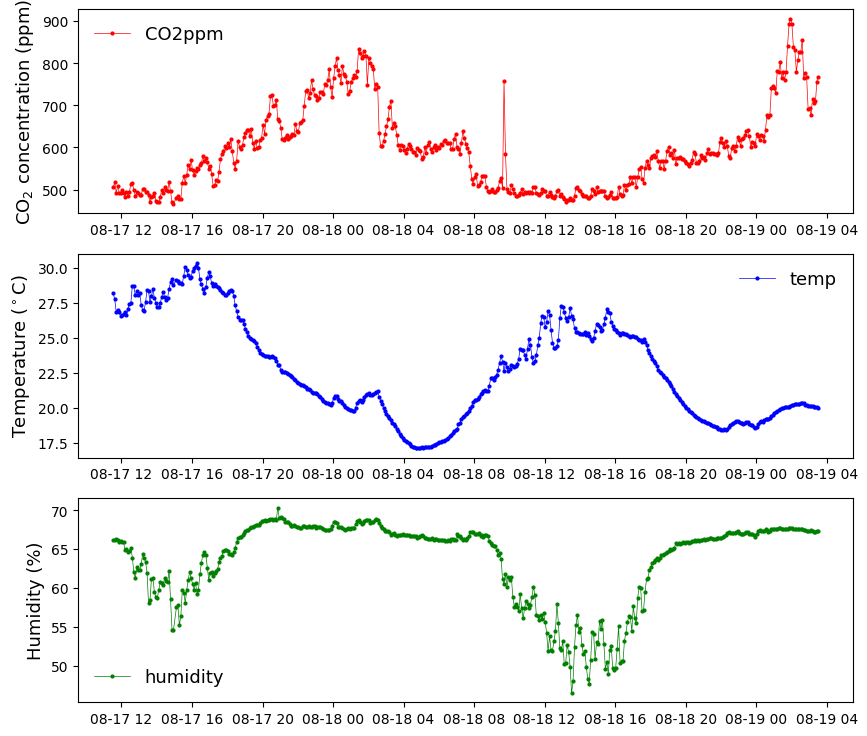

In [18]:
# prompt: make a graph with 3 subgraphs on in top of the other

import matplotlib.pyplot as plt
fig, axs = plt.subplots(3, 1, figsize=(10, 9))

axs[0].plot(data_set['timestamp'], data_set['CO2ppm'], '-ro', linewidth=0.5, markersize=2, label='CO2ppm')
axs[0].set_ylabel(r'CO$_2$ concentration (ppm)', fontsize=13)
axs[0].legend(loc="best", frameon=False, fontsize=13)

axs[1].plot(data_set['timestamp'], data_set['temp'], '-bo', linewidth=0.5, markersize=2, label='temp')
axs[1].set_ylabel(r'Temperature ($^\circ$C)', fontsize=13)
axs[1].legend(loc="best", frameon=False, fontsize=13)

axs[2].plot(data_set['timestamp'], data_set['humidity'], '-go', linewidth=0.5, markersize=2, label='humidity')
axs[2].set_ylabel(r'Humidity (%)', fontsize=13)
axs[2].legend(loc="best", frameon=False, fontsize=13)

plt.show()


### Divide the data into Train and Test datasets

In [147]:
# Labels are the values we want to predict
labels = np.array(data_set['CO2ppm'])
datas_ok = data_set['timestamp']

features = data_set.drop(['CO2ppm'], axis = 1)
features = features.drop(['timestamp'], axis = 1)

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features_array = np.array(features)

In [148]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features_array, labels, test_size = 0.2, random_state = 42)
datas_treinamento, datas_testes = train_test_split(data_set['timestamp'], test_size = 0.2, random_state = 42)

In [149]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (384, 2)
Training Labels Shape: (384,)
Testing Features Shape: (96, 2)
Testing Labels Shape: (96,)


## Creating a baseline model - Multiple Linear Regression

For CO2 prediction we will use the Multiple Linear Regression model as a baseline.

$$
\begin{aligned}
& y_i=\beta_0+\beta_1 x_{i 1}+\beta_2 x_{i 2}+\ldots+\beta_p x_{i p}+\epsilon \\
& \text { where, for } i=n \text { observations: } \\
& y_i=\text { dependent variable } \\
& x_i=\text { explanatory variables } \\
& \beta_0=\text { y-intercept (constant term) } \\
& \beta_p=\text { slope coefficients for each explanatory variable } \\
& \epsilon=\text { the model's error term (also known as the residuals) }
\end{aligned}
$$

In [150]:
df_train_features = pd.DataFrame(data=train_features, columns=feature_list)
df_train_features

,temp,humidity
0,21.326520,67.998716
1,17.981335,66.103200
2,20.133133,67.365723
3,29.165917,57.496643
4,24.879570,57.215881
...,...,...
379,23.649488,68.880124
380,23.041878,61.423950
381,25.300941,54.246673
382,18.628159,66.775665


In [151]:
df_test_features = pd.DataFrame(data=test_features, columns=feature_list)
df_test_features

,temp,humidity
0,28.288504,64.144134
1,18.388367,66.595764
2,19.467697,66.039276
3,24.110527,57.440643
4,19.130440,66.195831
...,...,...
91,17.534693,66.159063
92,19.313016,66.138784
93,18.663406,66.371002
94,27.552702,58.452868


In [152]:
df_train_labels = pd.DataFrame(data=train_labels, columns=['CO2ppm'])
df_test_labels = pd.DataFrame(data=test_labels, columns=['CO2ppm'])
#df_test_labels

In [153]:
x = np.array(df_train_features[['temp','humidity']], dtype=float)
y = np.array(df_train_labels['CO2ppm'], dtype=float)


# with sklearn
regr = linear_model.LinearRegression()
regr.fit(x, y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

# with statsmodels
x = sm.add_constant(x) # adding a constant

model = sm.OLS(y, x).fit()
predictions = model.predict(x)

print_model = model.summary()
print(print_model)

Intercept: 
 30.963794183398704
Coefficients: 
 [-5.52626567 10.83679857]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                  0.497
Method:                 Least Squares   F-statistic:                     190.0
Date:                Mon, 19 Aug 2024   Prob (F-statistic):           5.67e-58
Time:                        17:57:47   Log-Likelihood:                -2178.4
No. Observations:                 384   AIC:                             4363.
Df Residuals:                     381   BIC:                             4375.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------

## Evaluating the Linear Regression Model

In [154]:
x_test = np.array(df_test_features[['temp','humidity']], dtype=float)
y_test = np.array(df_test_labels['CO2ppm'], dtype=float)

# with statsmodels
x_test = sm.add_constant(x_test) # adding a constant

test_predictions = model.predict(x_test)

In [155]:
# Linear Regression Model evaluation
print(f'root_of_mean_squared_error : {mean_squared_error(y_test, test_predictions)**0.5} ppm')

root_of_mean_squared_error : 69.77053376160866 ppm


In [156]:
df_train_features['Baseline(MLR)'] = predictions
df_test_features['Baseline(MLR)'] = test_predictions
df_train_features

,temp,humidity,Baseline(MLR)
0,21.326520,67.998716,649.996162
1,17.981335,66.103200,647.941228
2,20.133133,67.365723,649.731518
3,29.165917,57.496643,492.864730
4,24.879570,57.215881,513.509661
...,...,...,...
379,23.649488,68.880124,646.710472
380,23.041878,61.423950,569.267232
381,25.300941,54.246673,479.004343
382,18.628159,66.775665,651.654077


# Random Forest model for predicting CO2 ppm levels in Järvselja

In [157]:
# Use numpy to convert to arrays
import numpy as np

baseline = df_train_features['Baseline(MLR)']
baseline_array = np.array(df_train_features['Baseline(MLR)'])

In [158]:
df_train_features.columns

Index(['temp', 'humidity', 'Baseline(MLR)'], dtype='object')

In [159]:
df_train_labels.columns

Index(['CO2ppm'], dtype='object')

In [160]:
df_train_features

,temp,humidity,Baseline(MLR)
0,21.326520,67.998716,649.996162
1,17.981335,66.103200,647.941228
2,20.133133,67.365723,649.731518
3,29.165917,57.496643,492.864730
4,24.879570,57.215881,513.509661
...,...,...,...
379,23.649488,68.880124,646.710472
380,23.041878,61.423950,569.267232
381,25.300941,54.246673,479.004343
382,18.628159,66.775665,651.654077


In [161]:
# Remove the labels from the features
# axis 1 refers to the columns
df_train_features = df_train_features.drop(['Baseline(MLR)'], axis = 1)

print(df_train_features.columns)
df_train_features

Index(['temp', 'humidity'], dtype='object')


,temp,humidity
0,21.326520,67.998716
1,17.981335,66.103200
2,20.133133,67.365723
3,29.165917,57.496643
4,24.879570,57.215881
...,...,...
379,23.649488,68.880124
380,23.041878,61.423950
381,25.300941,54.246673
382,18.628159,66.775665


In [162]:
type(train_features), type(train_labels)

(numpy.ndarray, numpy.ndarray)

In [163]:
train_features.shape

(384, 2)

In [164]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Instantiate model with 1000 decision trees (aumentei para 1000)
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

# Train the model on training data
rf.fit(train_features, train_labels);

In [165]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
y_test = test_labels

# Linear Regression Model evaluation
print(f'root_of_mean_squared_error : {mean_squared_error(y_test,predictions)**0.5} ug/m3')

root_of_mean_squared_error : 33.92367813408382 ug/m3


In [166]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: humidity             Importance: 0.74
Variable: temp                 Importance: 0.26


Text(0.5, 0, 'Random Forest Feature Importance')

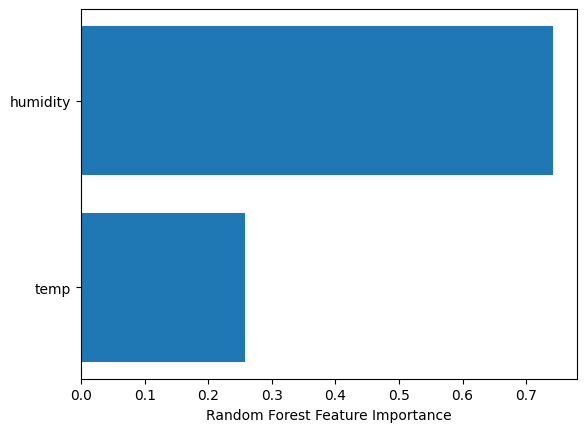

In [167]:
sorted_idx = rf.feature_importances_.argsort()
plt.barh(df_train_features.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

## Graph comparing predictions with measured values

In [168]:
x = test_labels
y = predictions

In [174]:
y2 = test_predictions

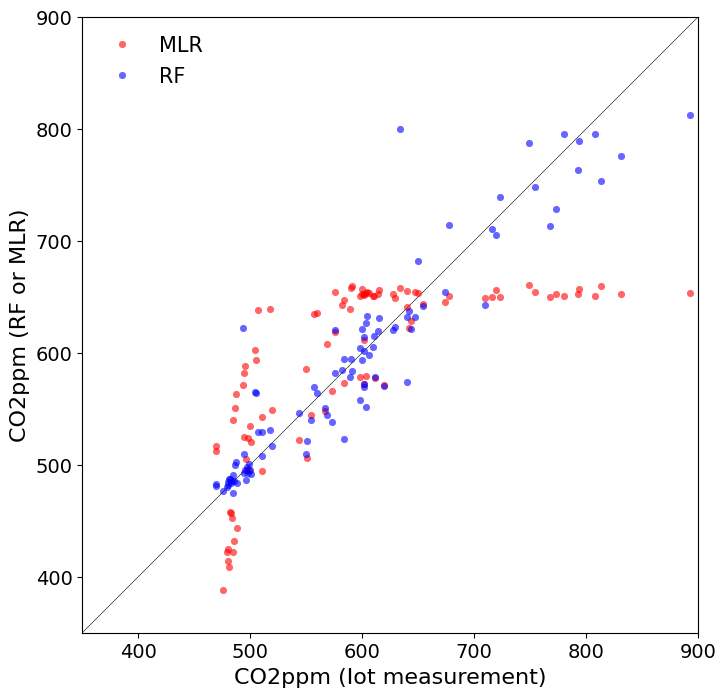

In [194]:
z = np.array([0, 1000])
plt.figure(figsize=(8,8))
plt.plot(z,z,color='black',linewidth=0.4)
plt.gca().set_aspect('equal', adjustable='box')

plt.xlim(350,900)
plt.ylim(350,900)
plt.plot(x[1:],y2[1:],'o', color='red' ,markersize = 5, markeredgewidth = 0.1, alpha =0.6,label='MLR')
plt.plot(x[1:],y[1:],'o', color='blue',markersize = 5, markeredgewidth = 0.1, alpha =0.6,label='RF')

plt.tick_params(axis='both', labelsize=14) #increase font size for ticks

#for line in leg.get_lines():
#    line.set_linewidth(1.0)
plt.legend(loc=2, prop={'size': 15},frameon=False)
plt.ylabel('CO2ppm (RF or MLR)', fontsize=16)
plt.xlabel('CO2ppm (Iot measurement)', fontsize=16)
plt.savefig('resultado_RF+MLR.png', dpi = 300)
plt.show()

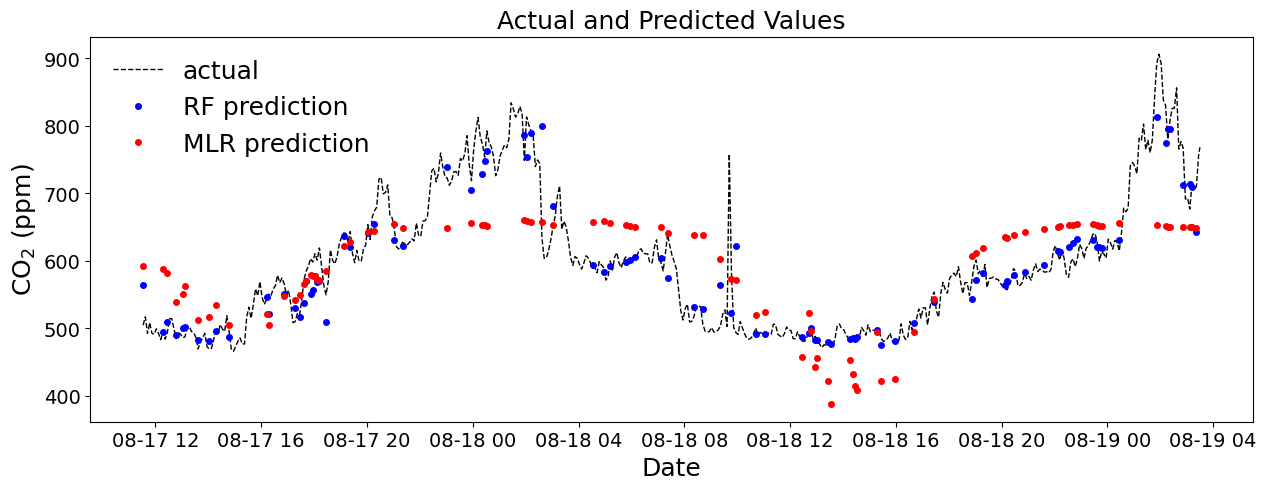

In [197]:
# Dataframe with true values and dates
true_data = pd.DataFrame(data = {'date': datas_ok, 'actual': labels})


plt.figure(figsize=(15,5))

plt.tick_params(axis='both', labelsize=14) #increase font size for ticks

# Dataframe with predictions and dates
predictions_data = pd.DataFrame(data = {'date': datas_testes, 'prediction': predictions})
# Plot the actual values
plt.plot(true_data['date'], true_data['actual'], 'k--', label = 'actual',linewidth=1)
# Plot the predicted values
plt.plot(predictions_data['date'], predictions_data['prediction'], 'bo', markersize=4, label = 'RF prediction')
plt.plot(predictions_data['date'], test_predictions, 'ro', markersize=4, label = 'MLR prediction')
plt.xticks(rotation = 'horizontal');
plt.legend()
# Graph labels
plt.xlabel('Date', fontsize=18); plt.ylabel(r'CO$_2$ (ppm)', fontsize=18); plt.title('Actual and Predicted Values', fontsize=18);
plt.legend(loc="best", frameon=False, fontsize=18)

plt.savefig('serie_temporal_geral.png', dpi = 300)


# What we have learned?

- RF is a nice Machine Learning model for making predicitons
- humidity is an important variable, then comes temperature
- linear model is not good for making a prediciton

## What can we do now?

- Compare Vaisala CO2 sensor with SCD41 sensor and propose a correction based on RF
- Use Artificial Neural Networks (ANN) to make the prediction or a low cost sensor correction
- A good candidate is LSTM (Long Short Term Memory) ANN